In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [8]:
def csvRead(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    return data

strawberry = csvRead('FLIGHT DATA/PCB 1 Strawberry/Strawberry_flash.csv')
cherry = csvRead('FLIGHT DATA/PCB 2 Cherry/Cherry_flash.csv')
darthPlagueis = csvRead('FLIGHT DATA/PCB 3 Darth Plagueis/DarthPlagueis_flash.csv')
apple = csvRead('FLIGHT DATA/PCB 4 Apple/Apple_flash.csv')

In [16]:
def filterData(array):
    deployedRow = np.where(array[:,0] == 1)[0][0]
    landedRow = np.where(array[:,0] == 4)[0][0]
    return array[deployedRow-250:landedRow+100]

def filterData2(array, deployedRow, landedRow):
    return array[deployedRow-250:landedRow+100]

def stateTransitionRows(array):
    rows = []
    for i in range(1,5):
        rows.append(np.where(array[:,0] == i)[0][0])
    return rows

def seaLevel(pressure, altitude):
    return pressure / pow(1.0 - (altitude / 44330.76), 5.25588);

def addAltitudeColumns(array, seaLevel):
    pressureCol = array[:,3]
    altitudeCol = 44330.76 * (1.0 - pow(pressureCol / seaLevel, 1.0 / 5.25588))
    withAlt = np.concatenate((array, np.expand_dims(altitudeCol, 1)), axis=1)
    
    processedAltitude = np.zeros((pressureCol.shape[0], 3))
    for i in range (altitudeCol.shape[0]):
        if (i < 40):
            processedAltitude[i,0] = np.average(altitudeCol[:i+1])
        else:
            processedAltitude[i,0] = np.average(altitudeCol[i-39:i+1])
    processedAltitude[0,1] = 0
    for i in range (1, altitudeCol.shape[0]):
        processedAltitude[i,1] = (processedAltitude[i,0] - processedAltitude[i-1,0]) * 20
    for i in range (altitudeCol.shape[0]):
        if (i < 40):
            processedAltitude[i,2] = np.average(processedAltitude[:i+1, 1])
        else:
            processedAltitude[i,2] = np.average(processedAltitude[i-39:i+1, 1])
    return np.concatenate((withAlt, processedAltitude), axis=1)

def plotData(array, headers, lineColor):
    timeCol = 1
    yColumns = [3, 16, 6, 4, 14, 18, 10, 13]
    numPlots = len(yColumns)
    plotColumns = (numPlots+1)//2
    stateChangeRows = []
    print('State changes at times: ', end=' ')
    for i in range(1,5):
        stateChangeRows.append(np.where(array[:,0] == i)[0][0])
        print(array[stateChangeRows[i-1], timeCol], end='  ')
    print()
    fig, axs = plt.subplots(2, plotColumns, figsize=(16, 6), sharex=True)
    for i in range(numPlots):
        currentAx = axs[i//plotColumns, i%plotColumns]
        currentAx.plot(array[:,timeCol], array[:,yColumns[i]], linewidth=0.5, color=lineColor)
        currentAx.set_title(headers[yColumns[i]])
        for row in stateChangeRows:
            currentAx.axvline(array[row,timeCol], color='black', linewidth=0.5)
            
def plotData2(array, headers, lineColor):
    timeCol = 1
    yColumns = [3, 16, 6, 4, 14, 18, 10, 13]
    numPlots = len(yColumns)
    plotColumns = (numPlots+1)//2
    fig, axs = plt.subplots(2, plotColumns, figsize=(16, 6), sharex=True)
    for i in range(numPlots):
        currentAx = axs[i//plotColumns, i%plotColumns]
        currentAx.plot(array[:,timeCol], array[:,yColumns[i]], linewidth=0.5, color=lineColor)
        currentAx.set_title(headers[yColumns[i]])

In [17]:
dataHeaders = ['State', 'Time (s)', 'Time (ms)', 'Pressure [Pa]', 'Temperature (C)', 'Temperature (C/100)',
               'Accel (G)', 'Accel X', 'Accel Y', 'Accel Z',
               'Batt Sense', 'Cut Sense 1', 'Cut Sense 2', 'Current Sense', 'Photoresistor',
               'Altitude (m)', 'Smoothed Altitude (m)', 'Delta Altitude (m/s)', 'Smoothed Delta Altitude (m/s)']
dataSets = [strawberry, cherry, darthPlagueis, apple]

def blackMagic(array, lineColor, pressure, altitude):
    
    plotData(addAltitudeColumns(filterData(array), seaLevel(pressure, altitude)), dataHeaders, lineColor)
    
def blackMagic2(array, lineColor, pressure, altitude, deployedRow, landedRow):
    plotData2(addAltitudeColumns(filterData2(array, deployedRow, landedRow), seaLevel(pressure, altitude)), dataHeaders, lineColor)

# Andy's flight

The line cutters were packed too tightly in the rocket, so the parachute did not properly deploy. As a result, the line cutters never got the readings needed to move into a "deployed" state (this is good, they didn't cut prematurely). PCB 1 appears to have reset when the rocket hit the ground, and it erased the flight data on startup--that will be changed in the next iteration of the code.

The photoresistors on both PCBs detected deployment once they were exposed to light. The lines were cut immediately after, since the boards were below their cut altitudes. In the graphs, you can see where the state changes happened for each PCB, as well as the actual flight data from PCB 2.

## Strawberry (PCB 1)

State changes at times:  160.718  163.443  166.199  172.666  


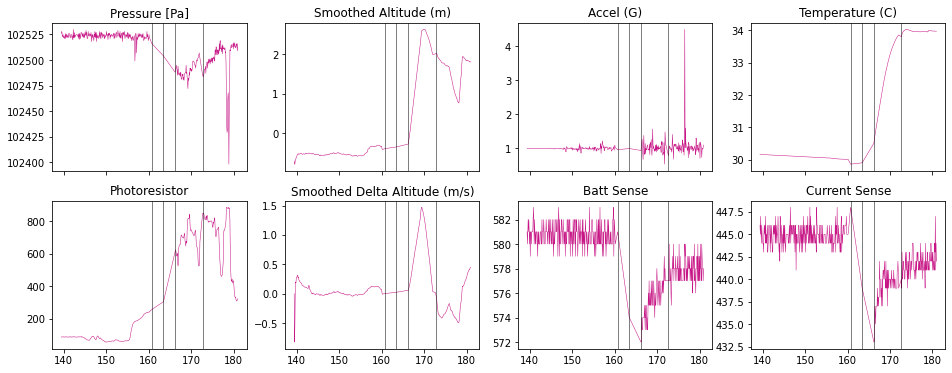

In [18]:
blackMagic(strawberry, 'mediumvioletred', 102522, -0.37)

## Cherry (PCB 2)

State changes at times:  3003.411  3006.101  3008.828  3015.383  


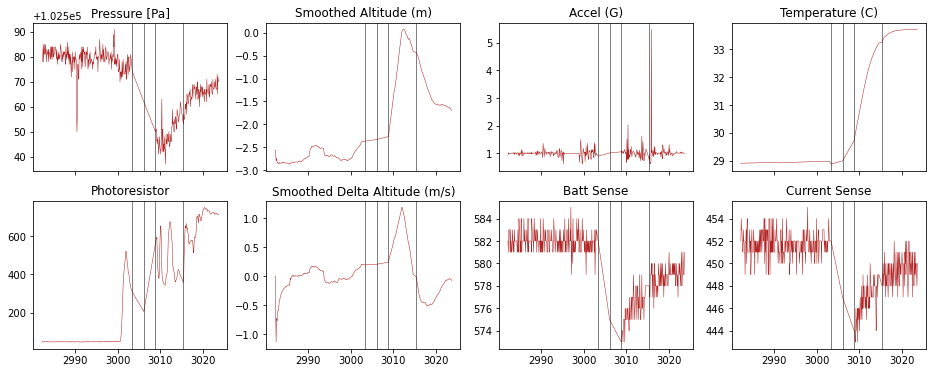

In [19]:
blackMagic(cherry, 'firebrick', 102581, -2.81)

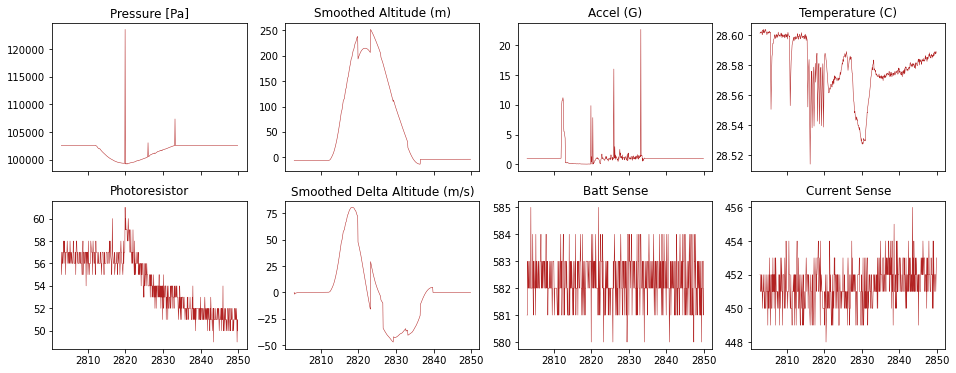

In [20]:
blackMagic2(cherry, 'firebrick', 102581, -2.81, 33300, 33500)

# Matt's flight

Both PCBs detected deployment when the velocity dipped below -3 m/s (good). Both then disreefed on the next tick (not good). Since they were still in the rocket, there was less tension on the lines and the nichrome didn't burn through. This premature disreef was because of a code mistake where the time since last state change was calculated to be near the max integer value (which is, of course, longer than the time delay used to trigger a backup disreef).

Both lines ended up being cut by the backup perfboard, which doesn't extensively log data.

## Darth Plagueis (PCB 3)

State changes at times:  2070.898  2073.75  2076.645  2120.441  


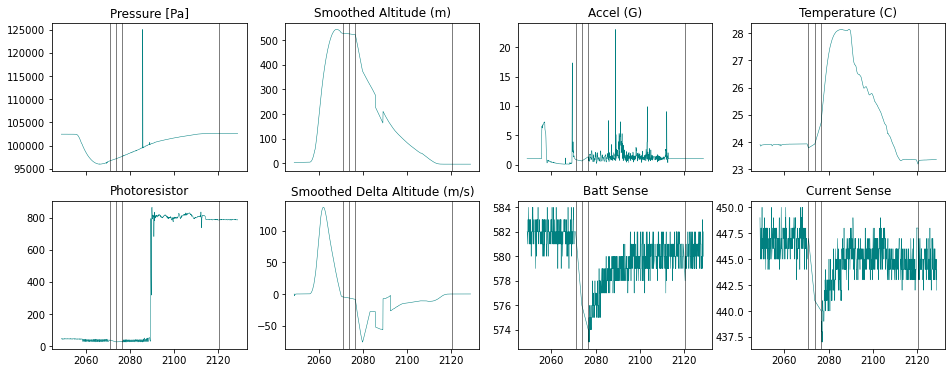

In [46]:
blackMagic(darthPlagueis, 'teal', 96549, 502.00)

## Apple (PCB 4)

State changes at times:  2195.947  2198.694  2201.5  2245.517  


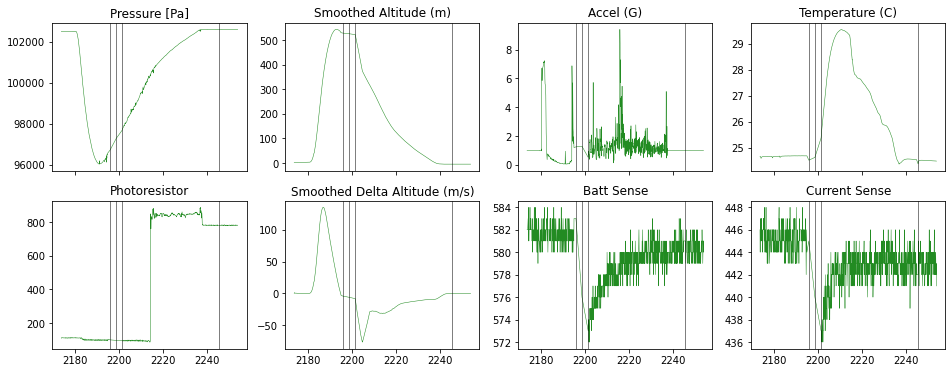

In [47]:
blackMagic(apple, 'forestgreen', 96595, 500.28)